### Курсовой проект для курса "Python для Data Science"

**Материалы к проекту (файлы):**
train.csv
test.csv

**Задание:**
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

**Целевая переменная:**
Price

**Метрика:**
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Сдача проекта:**
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

**Сроки и условия сдачи:**
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

**Примечание:**
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

**Рекомендации для файла с кодом (ipynb):**
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.


In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from pylab import rcParams

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

**Заргузка данных**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
print(train_df.shape)
train_df.head()

(10000, 20)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [67]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [5]:
train_df.describe(include='all')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9903,9725,NaN,NaN,NaN,NaN,NaN,NaN,9175,NaN
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,NaN,NaN,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,NaN,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,NaN,NaN,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,NaN,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,NaN,NaN,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,NaN,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,NaN,NaN,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,NaN,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,NaN,NaN,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,NaN,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,NaN,NaN,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,NaN,249135.462171


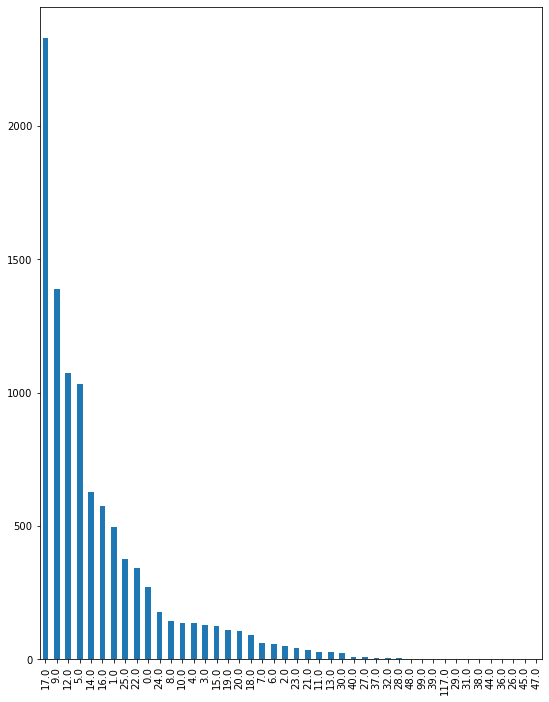

In [33]:
rcParams["figure.figsize"] = 9, 12
train_df['HouseFloor'].value_counts().plot(kind='bar')
plt.show()

In [6]:
train_df['HouseFloor'][train_df['HouseFloor'] < train_df['Floor']].count()

1825

In [186]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
train_df.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

In [8]:
train_df['Floor'][train_df['HouseFloor'] == 0].count()

269

In [9]:
train_df[train_df['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,46.072913,48.307844,0.0,4,0.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.094034
9769,9384,59,3.0,98.607328,NaN,0.0,14,0.0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.257473
9878,11441,62,2.0,71.985335,72.453232,0.0,5,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,158841.624543
9908,3171,62,1.0,35.873961,NaN,0.0,25,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,134379.130962


**Замена символьных значений в категориальных переменных**

In [15]:
train_df.replace({'Ecology_2':{'A':0, 'B':1}, 'Ecology_3':{'A':0, 'B':1}, 'Shops_2':{'A':0, 'B':1}}, inplace=True)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,NaN,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


**Разбиение датафрейма на трейн и валид**

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split (train_df.set_index('Id').drop(['LifeSquare', 'Healthcare_1', 'Price'], axis='columns'), train_df['Price'], test_size=0.2, random_state=22)

**Построение базовой модели**

In [ ]:
model_RFR = RandomForestRegressor(max_depth=15, max_features=7, min_samples_leaf=3, min_samples_split=8, n_estimators=30000, random_state=55, n_jobs=12)
model_RFR.fit(X_train, y_train)
train_first_predict = model_RFR.predict(X_train)
valid_first_predict = model_RFR.predict(X_valid)
print(f'{r2(y_train, train_first_predict)}')
print(f'{r2(y_valid, valid_first_predict)}')

**Первое предсказание на тестовой модели**

In [151]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [155]:
test_df.replace({'Ecology_2':{'A':0, 'B':1}, 'Ecology_3':{'A':0, 'B':1}, 'Shops_2':{'A':0, 'B':1}}, inplace=True)
test_df.head()

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [157]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,NaN,0,0,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,NaN,3,3,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,NaN,0,0,0


**Первое предсказание с базовой модели на тестовых данных**

In [165]:
test_first_predict = model_RFR.predict(test_df.set_index('Id').drop(['LifeSquare', 'Healthcare_1'], axis='columns'))
test_df['Price'] = test_first_predict

ValueError: Number of features of the model must match the input. Model n_features is 16 and input n_features is 17 

In [180]:
len(model_RFR.feature_importances_)

16

In [181]:
test_df.set_index('Id').drop(['LifeSquare', 'Healthcare_1', 'Price'], axis='columns').columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [182]:
f_importance = pd.DataFrame()

In [183]:
f_importance['name'] = test_df.set_index('Id').drop(['LifeSquare', 'Healthcare_1', 'Price'], axis='columns').columns.tolist()

In [184]:
f_importance['values'] = model_RFR.feature_importances_

In [185]:
f_importance.sort_values('values', ascending = False).reset_index(drop=True)

,name,values
0,Square,0.463692
1,Social_1,0.118461
2,Social_2,0.109877
3,Rooms,0.100433
4,Social_3,0.056790
5,DistrictId,0.040764
6,Ecology_1,0.036121
7,KitchenSquare,0.017267
8,HouseYear,0.017199
9,Shops_1,0.012791
